In [5]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm

In [30]:
def gen_sample(n, mus, sigmas):
    return np.array([mus + stats.norm.rvs(size = n, loc = 0, scale = sigmas[i]) for i in np.arange(len(sigmas)) ])

def gen_mus_sigma(nb_stateux, nb_samples):
    return (stats.uniform.rvs(size=nb_samples, loc=0, scale=200), stats.uniform.rvs(size=nb_stateux, loc=0, scale=40))

nb_stateux = 7
sample_length = 4

(mus, sigma) = gen_mus_sigma(nb_stateux, sample_length)
sample = gen_sample(sample_length, mus, sigma)
print (len(sample), len(sample[0]))
print (mus)
print (sigma)
print (sample)
print ([np.mean([sample[i, j] for i in np.arange(len(sigma))]) for j in np.arange(len(mus))])

print (sample.shape)

7 4
[ 14.49126036  24.16197353  87.70223857  60.10582004]
[ 12.93385202  12.67588318  31.11432159  19.92530558  24.68227131
  27.43383161   5.20534499]
[[  12.03078685   24.832857     83.05092007   48.00986301]
 [  28.58636892   35.22776156   79.51976423   45.51522663]
 [  67.92999804    6.93565223  137.82356788   86.97856977]
 [  24.41458039   52.12518311  100.33281127   64.60699078]
 [  17.04519098   38.60769819   69.62896248   72.5159213 ]
 [   7.22399185   25.92920677   80.96944166   43.12249473]
 [  14.68246538   17.46807234   87.93859876   51.36223616]]
[24.559054628862079, 28.732347313650383, 91.323438048953705, 58.873043197730873]
(7, 4)


In [31]:
import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(20000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]

 [-----------------100%-----------------] 20000 of 20000 complete in 15.4 sec

In [32]:
%history -f 7stateux_model.py -l 1

File '7stateux_model.py' exists. Overwrite? y
Overwriting file.


11.7390613061
24.9124063422
82.6744835492
47.4399953394


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


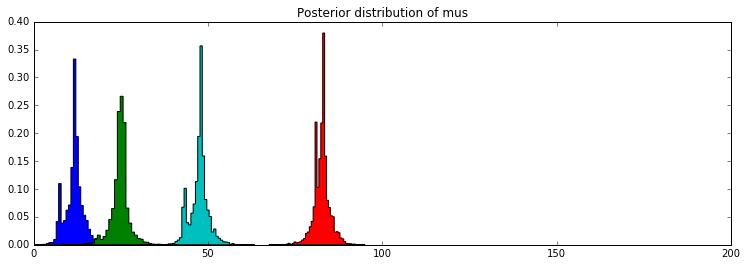

In [33]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean())

3.11097551488
16.1422200064
56.2734558156
29.4096715937
24.6325986195
5.9564861812
9.34934940595


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


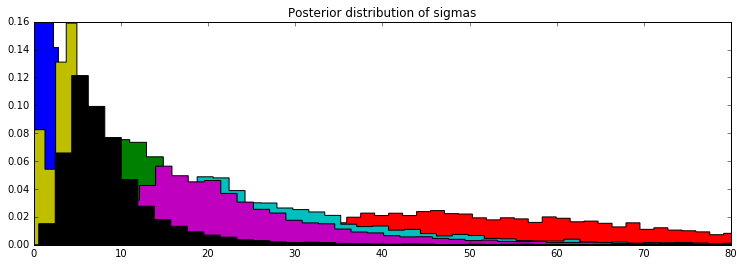

In [34]:
figsize(12.5, 4)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,80))
    print (sigma_traces[i].mean())

In [35]:
# Now going parallel

from IPython.parallel import Client
client = Client()

direct         = client[:]
direct.block   = True
print (direct)

def checkhostname():
    import socket
    return socket.gethostname()

direct.apply(checkhostname)

import numpy as np
with direct.sync_imports():
    import pymc as pm
    import numpy as np

<DirectView [0, 1, 2, 3]>
importing pymc on engine(s)
importing numpy on engine(s)


In [36]:
export_dict = {k: globals()[k] for k in ('sample', 'nb_stateux')}
direct.push(export_dict, block=True)

model_script = open('7stateux_model.py').read()
print (model_script)

import numpy as np
import pymc as pm

(nb_stateux, sample_length) = sample.shape

v_mus = np.array([pm.Normal("mu%d" % i, mu=0, tau=0.001) for i in np.arange(sample_length)])
v_sigmas = [pm.Uniform("sigma%d" % k, lower=0, upper=100) for k in np.arange(nb_stateux)]
v_taus = [pm.Lambda("tau%d" % k, lambda sigma=v_sigmas[k]: 1/sigma**2) for k in np.arange(nb_stateux)]

x = np.array([[pm.Normal("x%d_%d" % (k,i), mu=v_mus[i], tau=v_taus[k], 
                         observed=True, value=np.array(sample[k,i])) for i in np.arange(sample_length)]
              for k in np.arange(nb_stateux)])

mcmc = pm.MCMC([v_mus, v_sigmas, v_taus, x])
mcmc.sample(20000,1000)

mu_traces = [np.array(mcmc.trace('mu%d' % k)[:]) for k in np.arange(sample_length)]
sigma_traces = [np.array(mcmc.trace("sigma%d" % i)[:]) for i in np.arange(nb_stateux)]



In [37]:
direct.execute(model_script)

<AsyncResult: finished>

In [38]:
def get_trace(var_name):
    all_traces = direct.pull(var_name)
    a = len(all_traces)
    b = len(all_traces[0])

    y = [np.array([all_traces[i][j] for i in range(a)]).flatten() for j in range(b)]
    
    return y

mu_traces = get_trace("mu_traces")
sigma_traces = get_trace("sigma_traces")

print (mu_traces)
print (len(mu_traces), len(mu_traces[0]))

[array([ 11.96216857,  11.96216857,  11.96216857, ...,  11.13932379,
        11.13932379,  11.13932379]), array([ 23.91339875,  25.63216794,  25.63216794, ...,  23.85862755,
        23.85862755,  23.85862755]), array([ 82.12263724,  82.12263724,  82.12263724, ...,  87.49621377,
        82.58866466,  82.58866466]), array([ 48.31800337,  48.31800337,  48.29049752, ...,  46.69276436,
        46.69276436,  46.69276436])]
4 76000


12.2596462266
24.91937009
82.7035896346
47.6222678434


/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


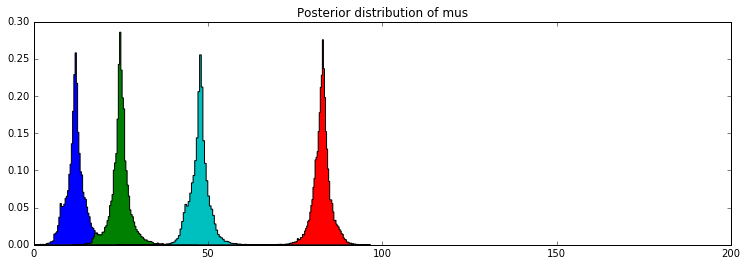

In [39]:
figsize(12.5, 4)
plt.title("Posterior distribution of mus")
for i in np.arange(sample_length):
    plt.hist(mu_traces[i], bins=100, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,200))
    print (mu_traces[i].mean()), mus[i]

/home/yannick/bin/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


3.56702857675 2.59266134413 12.9338520227
15.8290507263 13.1870886556 12.6758831764
56.3240414563 53.7453287263 31.1143215862
29.1368124531 24.9789614198 19.9253055832
24.44463009 20.8196235427 24.6822713137
6.53817668983 5.17548201691 27.4338316098
8.73021900359 7.07254960783 5.2053449931


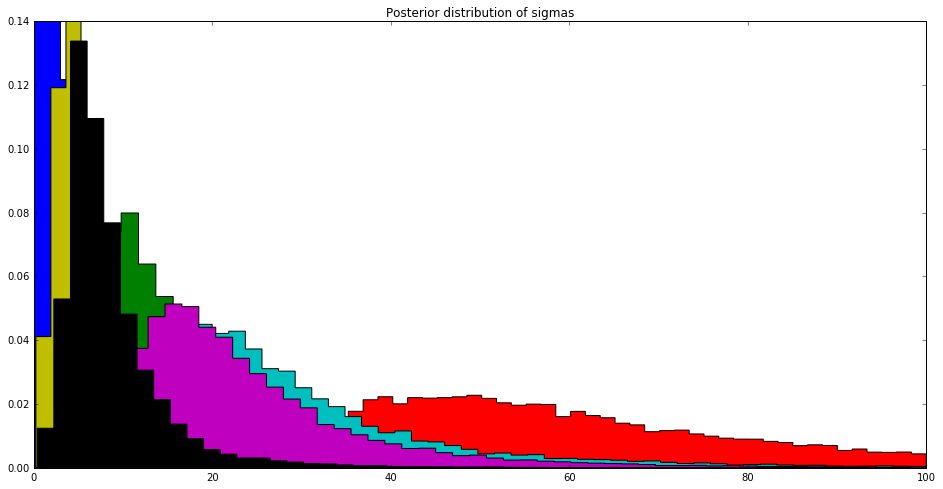

In [40]:
figsize(16, 8)
plt.title("Posterior distribution of sigmas")
for i in np.arange(nb_stateux):
    plt.hist(sigma_traces[i], bins=50, histtype="stepfilled", normed=True)
    plt.legend()
    plt.xlim((0,100))
    print (sigma_traces[i].mean(), np.median(sigma_traces[i]), sigma[i])